In [1]:
import numpy as np
from utils import open_llc2160, compute_land_ocean_mask3d, apply_land_ocean_mask
import matplotlib.pyplot as plt

In [2]:
db_theta = open_llc2160("theta")

time = 0
quality = -10

theta_3d = db_theta.read(time=time, quality=quality,)

mask_3d = compute_land_ocean_mask3d(
    time=time,
    quality=quality)

theta3d_ocean = apply_land_ocean_mask(theta_3d, mask_3d, land_value=np.nan)


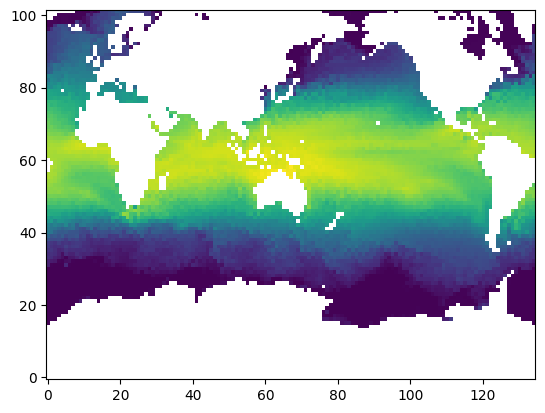

In [3]:
plt.imshow(theta3d_ocean[0,:,:],origin='lower')